# 1 Etude du problème d’optimisation





#### Q1 
La minimisation de $K(x_{N}-L/2)$ permet de répondre à la contrainte d'arrosage : on doit arroser le parterre de fleur situé en (0,1). On cherche donc à minimiser la distance du bout du tuyau à ce point d'intérêt. 
La minimisation de SOMME traduit la minimisation de la hauteur moyenne du tuyau (selon l'axe y). En minimisant cette somme : on cherche à "compacter" le tuyau proche de l'axe x.


#### Q2
La valeur initiale qu'on doit donner au solveur doit vérifier les contraintes. Il serait compliqué de trouver/prouver l'existence d'une telle solution ie avec deux conditions aux bords ainsi qu'une condition de courbure (la courbure à des conditions aux bords et elle est bornée).

#### Q3
Les $y_{i}\mapsto\lvert y_{i}\rvert$ ne sont pas différentiables sur $\mathbb{R}$. Ce manque de régularité pose évidemment problème dans l'algorithme de minimisation. 



#### Q4



#### Q5
On considère la variable de décision : 
$z = (\theta_{i},x_{i},y_{i},w_{i})$



# 2 Etude et résolution numériques


#### Q6
On peut implémenter un algorithme de résolution avec Scipy ou Casadi.


#### Q7

-0.21406068356382152
0.2
[ 1.          1.          0.95751407  0.91502814  0.87254221  0.83005628
  0.78757036  0.74508443  0.7025985   0.66011257  0.61762664  0.57514071
  0.53265478  0.49016885  0.44768292  0.405197    0.36271107  0.32022514
  0.27773921  0.23525328  0.19276735  0.15028142  0.10779549  0.06530956
  0.02282364 -0.01966229 -0.06214822 -0.10463415 -0.14712008 -0.18960601
 -0.23209194 -0.27457787 -0.31706379 -0.35954972 -0.40203565 -0.44452158
 -0.48700751 -0.52949344 -0.57197937 -0.6144653  -0.65695123 -0.69943715
 -0.74192308 -0.78440901 -0.82689494 -0.86938087 -0.9118668  -0.95435273
 -0.99683866 -1.03932459]


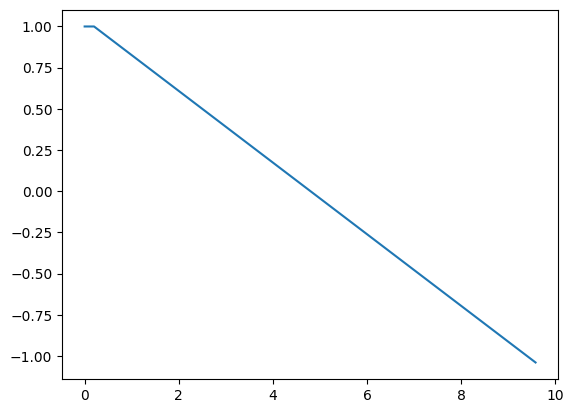

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

K=1
N=50
L=10
ds=L/N
a=1
thetamax=a*ds

##1)on trouve dans un premier temps la condition initiale :
m=N+(N+1)+(N+1)+(N+1)
z=np.zeros(m) #theta initial est nul
#en tracant la droite reliant les point (1,0) et (0,L) en prenant compte des theta initial et final, theta est donc constant
theta = -np.arctan(1/((L-2*ds))
z[2*N+1]=1
z[3*N+2]=1
for i in range (1,N-1) :
    z[i]=theta
for i in range (N+1,2*N+1):
    for j in range (i) :
        z[i]=z[i-1]+ds*np.cos(z[i-(N+1)])
        z[i+N+1]=z[i+N]+ds*np.sin(z[i-(N+1)])
        z[i+2*(N+1)]=z[i+N+1]
print (theta)
print(thetamax)
print(z[2*N+1:3*N+1])
plt.plot(z[N:2*N],z[2*N+1:3*N+1])
    
    



##on def la fonction à minimiser 
#def f_cout(z):
    
    #return 